# Steps
1. Load data
2. Preprocess
3. TFIDF


_______
## 1. Imports/ Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot

In [2]:
df = pd.read_csv('data/JEOPARDY_CSV.csv', date_parser=[' Air Date'])

In [3]:
new_cols = {s:s.strip() for s in df.columns}
df = df.rename(columns=new_cols)

In [9]:
def has_link(cell):
    if '<a' in cell and 'a>' in cell:
        return True
    else:
        return False
        

In [10]:
df['Has Link'] = df['Question'].apply(lambda x: has_link(x))

In [11]:
# For things without answers, we can drop
reduced_df = df.dropna()
reduced_df = reduced_df[reduced_df['Has Link'] == False]
df.shape, reduced_df.shape

((216930, 8), (206431, 8))

In [12]:
reduced_df['Year'] = reduced_df['Air Date'].apply(lambda x: x.split('-')[0])

In [13]:
reduced_df['Text'] = reduced_df['Question'] + ' ' + reduced_df['Answer']

jeopardy_df = reduced_df[reduced_df['Round'] == 'Jeopardy!']


________
## 2. Preprocess

In [24]:
import spacy
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [174]:
from textblob import TextBlob

nlp = spacy.load("en")


# def get_noun_chunks(cell):
#     blob = TextBlob(cell)
#     return blob.noun_phrases
    
#     doc = nlp(cell)
    
#     res = []
#     for noun in doc.noun_chunks: # use np instead of np.text
#         res.append(str(noun))
    
#     return ' '.join(res)
    
def normalize_text(cell):
    # Remove punctuation:
#     tokens = []
#     for c in cell:
#         c = c.lower()
#         c = c.translate(str.maketrans('', '', string.punctuation))
#         wordnet_lemmatizer = WordNetLemmatizer()
#         token_list = word_tokenize(c)
#         res = []
#         for w in token_list:
#             if w not in stopwords.words('english'):
#                 res.append(wordnet_lemmatizer.lemmatize(w))
#         tokens.append(' '.join(res))
#     return tokens
    cell = cell.lower()
    cell = cell.translate(str.maketrans('', '', string.punctuation))
    wordnet_lemmatizer = WordNetLemmatizer()
    token_list = word_tokenize(cell)
    words = []
    for w in token_list:
        if w not in stopwords.words('english') and 'httpwww' not in w:
            words.append(wordnet_lemmatizer.lemmatize(w))
    return ' '.join(words)
    
        

In [175]:
# jeopardy_df['Text Nouns'] = jeopardy_df['Text'].apply(lambda x: get_noun_chunks(x))

In [176]:
jeopardy_df['Norm Text'] = jeopardy_df['Text'].apply(lambda x: normalize_text(x))

<ipython-input-176-047e66aa1412>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeopardy_df['Norm Text'] = jeopardy_df['Text'].apply(lambda x: normalize_text(x))


_______
## Find which k to choose with Coherence scores

In [119]:
# from gensim.test.utils import common_texts
# from gensim.corpora.dictionary import Dictionary
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.models import LdaModel

### Preprocess with gensim

In [231]:
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import re
import logging
import gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)
stop_words = stopwords.words('english')

In [121]:
# from gensim.utils import lem

In [122]:
# from nltk.stem import WordNetLemmati

In [123]:
# def lemmitize(document, pos_dict):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(document, pos_dict.get(document, 'n')))

# def preprocess(document, pos_dict):
#     output = []
#     for token in gensim.utils.simple_preprocess(document):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             print("lemmitize: ", lemmitize(token, pos_dict))
#             output.append(lemmitize(token, pos_dict))
#     return output

In [124]:
# # Step 2: Prepare Data (Remove stopwords and lemmatize)
# data_processed = []

# for i, doc in enumerate(common_texts[:100]):
#     doc_out = []
#     for wd in doc:
#         if wd not in stop_words:  # remove stopwords
#             lemmatized_word = lemmitize(wd, pos_dict=re.compile('(NN|JJ|RB)'))  # lemmatize
#             if lemmatized_word:
#                 doc_out = doc_out + [lemmatized_word[0].split(b'/')[0].decode('utf-8')]
#         else:
#             continue
#     data_processed.append(doc_out)

# # Print a small sample    
# print(data_processed[0][:5]) 

In [232]:
common_texts = [i.split() for i in jeopardy_df['Text']]
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

2021-05-14 19:37:33,583 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-05-14 19:37:33,791 : INFO : adding document #10000 to Dictionary(35471 unique tokens: ['8', 'Copernicus', 'For', 'Galileo', 'arrest']...)
2021-05-14 19:37:34,009 : INFO : adding document #20000 to Dictionary(55927 unique tokens: ['8', 'Copernicus', 'For', 'Galileo', 'arrest']...)
2021-05-14 19:37:34,221 : INFO : adding document #30000 to Dictionary(72121 unique tokens: ['8', 'Copernicus', 'For', 'Galileo', 'arrest']...)
2021-05-14 19:37:34,455 : INFO : adding document #40000 to Dictionary(85799 unique tokens: ['8', 'Copernicus', 'For', 'Galileo', 'arrest']...)
2021-05-14 19:37:34,704 : INFO : adding document #50000 to Dictionary(98282 unique tokens: ['8', 'Copernicus', 'For', 'Galileo', 'arrest']...)
2021-05-14 19:37:34,918 : INFO : adding document #60000 to Dictionary(109700 unique tokens: ['8', 'Copernicus', 'For', 'Galileo', 'arrest']...)
2021-05-14 19:37:35,126 : INFO : adding document #7000

In [233]:
k_info = {}
for k in range(1,50,10):
    lda = LdaModel(common_corpus, num_topics=k)
    cm = CoherenceModel(model=lda, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
    k_info[k] = cm.get_coherence()

2021-05-14 19:37:52,647 : WARNING : no word id mapping provided; initializing from corpus, assuming identity
2021-05-14 19:37:52,815 : INFO : using symmetric alpha at 1.0
2021-05-14 19:37:52,816 : INFO : using symmetric eta at 1.0
2021-05-14 19:37:52,832 : INFO : using serial LDA version on this node
2021-05-14 19:37:52,845 : INFO : running online (single-pass) LDA training, 1 topics, 1 passes over the supplied corpus of 102435 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2021-05-14 19:37:52,846 : INFO : PROGRESS: pass 0, at document #2000/102435
2021-05-14 19:37:52,969 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:37:52,976 : INFO : topic #0 (1.000): 0.040*"13" + 0.029*"12" + 0.027*"15" + 0.025*"43" + 0.021*"49" + 0.013*"19" + 0.012*"100" + 0.010*"218" + 0.008*"6" + 0.008*"41"
2021-05-14 19:37:52,976 : INFO : topic diff=2.681355, rho

2021-05-14 19:37:55,600 : INFO : topic diff=0.170460, rho=0.235702
2021-05-14 19:37:55,600 : INFO : PROGRESS: pass 0, at document #38000/102435
2021-05-14 19:37:55,728 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:37:55,733 : INFO : topic #0 (1.000): 0.042*"13" + 0.029*"12" + 0.028*"15" + 0.024*"43" + 0.021*"49" + 0.014*"100" + 0.013*"19" + 0.009*"6" + 0.009*"218" + 0.008*"41"
2021-05-14 19:37:55,734 : INFO : topic diff=0.170069, rho=0.229416
2021-05-14 19:37:56,038 : INFO : -8.794 per-word bound, 444.0 perplexity estimate based on a held-out corpus of 2000 documents with 30895 words
2021-05-14 19:37:56,039 : INFO : PROGRESS: pass 0, at document #40000/102435
2021-05-14 19:37:56,158 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:37:56,164 : INFO : topic #0 (1.000): 0.042*"13" + 0.029*"12" + 0.027*"15" + 0.024*"43" + 0.021*"49" + 0.014*"100" + 0.013*"19" + 0.009*"6" + 0.009*"218" + 0.008*"41"
2021

2021-05-14 19:37:58,775 : INFO : topic #0 (1.000): 0.042*"13" + 0.029*"12" + 0.027*"15" + 0.024*"43" + 0.021*"49" + 0.013*"100" + 0.013*"19" + 0.009*"6" + 0.009*"218" + 0.008*"41"
2021-05-14 19:37:58,775 : INFO : topic diff=0.139893, rho=0.164399
2021-05-14 19:37:58,776 : INFO : PROGRESS: pass 0, at document #76000/102435
2021-05-14 19:37:58,902 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:37:58,908 : INFO : topic #0 (1.000): 0.042*"13" + 0.030*"12" + 0.027*"15" + 0.024*"43" + 0.021*"49" + 0.013*"19" + 0.013*"100" + 0.009*"6" + 0.009*"218" + 0.008*"41"
2021-05-14 19:37:58,909 : INFO : topic diff=0.141792, rho=0.162221
2021-05-14 19:37:58,910 : INFO : PROGRESS: pass 0, at document #78000/102435
2021-05-14 19:37:59,033 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:37:59,039 : INFO : topic #0 (1.000): 0.041*"13" + 0.029*"12" + 0.027*"15" + 0.024*"43" + 0.021*"49" + 0.013*"100" + 0.013*"19" + 0.009

2021-05-14 19:38:01,552 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2021-05-14 19:38:01,559 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2021-05-14 19:38:01,564 : INFO : CorpusAccumulator accumulated stats from 12000 documents
2021-05-14 19:38:01,571 : INFO : CorpusAccumulator accumulated stats from 13000 documents
2021-05-14 19:38:01,578 : INFO : CorpusAccumulator accumulated stats from 14000 documents
2021-05-14 19:38:01,584 : INFO : CorpusAccumulator accumulated stats from 15000 documents
2021-05-14 19:38:01,590 : INFO : CorpusAccumulator accumulated stats from 16000 documents
2021-05-14 19:38:01,596 : INFO : CorpusAccumulator accumulated stats from 17000 documents
2021-05-14 19:38:01,602 : INFO : CorpusAccumulator accumulated stats from 18000 documents
2021-05-14 19:38:01,610 : INFO : CorpusAccumulator accumulated stats from 19000 documents
2021-05-14 19:38:01,617 : INFO : CorpusAccumulator accumulated stats from 20000 documents
2021-05-14

2021-05-14 19:38:02,154 : INFO : CorpusAccumulator accumulated stats from 102000 documents
2021-05-14 19:38:02,230 : WARNING : no word id mapping provided; initializing from corpus, assuming identity
2021-05-14 19:38:02,396 : INFO : using symmetric alpha at 0.09090909090909091
2021-05-14 19:38:02,397 : INFO : using symmetric eta at 0.09090909090909091
2021-05-14 19:38:02,413 : INFO : using serial LDA version on this node
2021-05-14 19:38:02,539 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 102435 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2021-05-14 19:38:02,541 : INFO : PROGRESS: pass 0, at document #2000/102435
2021-05-14 19:38:03,506 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:03,572 : INFO : topic #7 (0.091): 0.027*"12" + 0.024*"43" + 0.022*"19" + 0.022*"13" + 0.021*"15"

2021-05-14 19:38:07,683 : INFO : topic #3 (0.091): 0.096*"13" + 0.059*"12" + 0.036*"49" + 0.032*"15" + 0.017*"100" + 0.017*"19" + 0.017*"41" + 0.016*"43" + 0.013*"57" + 0.011*"66"
2021-05-14 19:38:07,685 : INFO : topic #1 (0.091): 0.060*"13" + 0.048*"15" + 0.041*"100" + 0.038*"43" + 0.027*"12" + 0.021*"49" + 0.017*"19" + 0.017*"179" + 0.015*"66" + 0.012*"145"
2021-05-14 19:38:07,687 : INFO : topic diff=0.047152, rho=0.377964
2021-05-14 19:38:07,691 : INFO : PROGRESS: pass 0, at document #16000/102435
2021-05-14 19:38:08,273 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:08,328 : INFO : topic #10 (0.091): 0.069*"43" + 0.030*"218" + 0.030*"15" + 0.024*"12" + 0.021*"6" + 0.019*"225" + 0.017*"100" + 0.016*"125" + 0.015*"234" + 0.015*"316"
2021-05-14 19:38:08,330 : INFO : topic #2 (0.091): 0.041*"49" + 0.030*"15" + 0.030*"43" + 0.029*"13" + 0.016*"17" + 0.015*"6" + 0.012*"100" + 0.011*"12" + 0.010*"19" + 0.010*"750"
2021-05-14 19:38:08,332 : I

2021-05-14 19:38:12,462 : INFO : topic #9 (0.091): 0.019*"29" + 0.012*"2005" + 0.012*"976" + 0.010*"13" + 0.009*"6065" + 0.008*"444" + 0.008*"12024" + 0.007*"1003" + 0.007*"1927" + 0.006*"2165"
2021-05-14 19:38:12,464 : INFO : topic #10 (0.091): 0.081*"43" + 0.030*"218" + 0.027*"6" + 0.027*"15" + 0.021*"12" + 0.020*"225" + 0.018*"125" + 0.017*"234" + 0.015*"316" + 0.015*"100"
2021-05-14 19:38:12,466 : INFO : topic diff=0.025998, rho=0.267261
2021-05-14 19:38:12,469 : INFO : PROGRESS: pass 0, at document #30000/102435
2021-05-14 19:38:12,946 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:13,001 : INFO : topic #3 (0.091): 0.103*"13" + 0.063*"12" + 0.042*"49" + 0.036*"15" + 0.019*"19" + 0.017*"41" + 0.016*"100" + 0.014*"57" + 0.013*"43" + 0.009*"17"
2021-05-14 19:38:13,004 : INFO : topic #0 (0.091): 0.044*"13" + 0.042*"49" + 0.033*"12" + 0.032*"15" + 0.025*"54" + 0.022*"19" + 0.021*"17" + 0.021*"7" + 0.015*"174" + 0.012*"125"
2021-05-14 19:3

2021-05-14 19:38:16,777 : INFO : topic #10 (0.091): 0.097*"43" + 0.033*"6" + 0.028*"218" + 0.025*"225" + 0.024*"15" + 0.022*"234" + 0.019*"12" + 0.018*"316" + 0.016*"125" + 0.015*"81"
2021-05-14 19:38:16,778 : INFO : topic #9 (0.091): 0.024*"29" + 0.020*"2005" + 0.014*"976" + 0.011*"6065" + 0.010*"1927" + 0.008*"1003" + 0.008*"3749" + 0.007*"6744" + 0.007*"2165" + 0.007*"1926"
2021-05-14 19:38:16,781 : INFO : topic diff=0.021329, rho=0.218218
2021-05-14 19:38:16,785 : INFO : PROGRESS: pass 0, at document #44000/102435
2021-05-14 19:38:17,265 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:17,323 : INFO : topic #3 (0.091): 0.102*"13" + 0.060*"12" + 0.041*"49" + 0.036*"15" + 0.019*"19" + 0.016*"100" + 0.015*"57" + 0.015*"41" + 0.011*"43" + 0.010*"66"
2021-05-14 19:38:17,324 : INFO : topic #0 (0.091): 0.041*"49" + 0.040*"13" + 0.031*"15" + 0.029*"12" + 0.028*"54" + 0.025*"17" + 0.023*"7" + 0.020*"19" + 0.017*"174" + 0.013*"125"
2021-05-14 19:

2021-05-14 19:38:20,397 : INFO : topic #2 (0.091): 0.024*"49" + 0.014*"293" + 0.014*"15" + 0.014*"750" + 0.011*"17" + 0.010*"43" + 0.009*"13" + 0.007*"3336" + 0.006*"1637" + 0.006*"13499"
2021-05-14 19:38:20,400 : INFO : topic diff=0.015354, rho=0.188982
2021-05-14 19:38:20,403 : INFO : PROGRESS: pass 0, at document #58000/102435
2021-05-14 19:38:20,840 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:20,895 : INFO : topic #6 (0.091): 0.103*"13" + 0.078*"12" + 0.050*"15" + 0.032*"49" + 0.029*"19" + 0.029*"218" + 0.027*"43" + 0.022*"41" + 0.022*"6" + 0.012*"144"
2021-05-14 19:38:20,897 : INFO : topic #1 (0.091): 0.049*"13" + 0.048*"100" + 0.048*"43" + 0.042*"15" + 0.027*"12" + 0.018*"49" + 0.015*"19" + 0.014*"179" + 0.014*"145" + 0.013*"194"
2021-05-14 19:38:20,900 : INFO : topic #7 (0.091): 0.017*"19" + 0.015*"7" + 0.015*"49" + 0.014*"15" + 0.011*"43" + 0.011*"153" + 0.009*"57" + 0.009*"66" + 0.008*"12" + 0.007*"2282"
2021-05-14 19:38:20,90

2021-05-14 19:38:24,522 : INFO : topic #8 (0.091): 0.050*"49" + 0.045*"15" + 0.037*"13" + 0.034*"17" + 0.019*"57" + 0.014*"34" + 0.013*"12" + 0.013*"66" + 0.012*"100" + 0.011*"174"
2021-05-14 19:38:24,525 : INFO : topic diff=0.014359, rho=0.169031
2021-05-14 19:38:24,529 : INFO : PROGRESS: pass 0, at document #72000/102435
2021-05-14 19:38:24,951 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:25,007 : INFO : topic #7 (0.091): 0.015*"7" + 0.014*"19" + 0.013*"49" + 0.011*"15" + 0.009*"153" + 0.009*"66" + 0.009*"43" + 0.008*"57" + 0.008*"2282" + 0.006*"41"
2021-05-14 19:38:25,009 : INFO : topic #3 (0.091): 0.094*"13" + 0.057*"12" + 0.039*"49" + 0.038*"15" + 0.021*"19" + 0.016*"100" + 0.016*"57" + 0.016*"41" + 0.011*"66" + 0.011*"17"
2021-05-14 19:38:25,012 : INFO : topic #8 (0.091): 0.052*"49" + 0.045*"15" + 0.038*"13" + 0.033*"17" + 0.019*"57" + 0.014*"34" + 0.013*"66" + 0.013*"12" + 0.012*"100" + 0.011*"174"
2021-05-14 19:38:25,015 : INFO 

2021-05-14 19:38:28,562 : INFO : topic #4 (0.091): 0.035*"43" + 0.027*"12" + 0.016*"13" + 0.013*"19" + 0.010*"15" + 0.008*"67" + 0.008*"6" + 0.008*"225" + 0.007*"125" + 0.007*"316"
2021-05-14 19:38:28,565 : INFO : topic diff=0.010808, rho=0.154303
2021-05-14 19:38:28,568 : INFO : PROGRESS: pass 0, at document #86000/102435
2021-05-14 19:38:28,990 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:29,045 : INFO : topic #1 (0.091): 0.053*"43" + 0.049*"100" + 0.047*"13" + 0.039*"15" + 0.028*"12" + 0.017*"49" + 0.015*"19" + 0.014*"179" + 0.013*"145" + 0.012*"194"
2021-05-14 19:38:29,048 : INFO : topic #0 (0.091): 0.042*"49" + 0.037*"13" + 0.032*"15" + 0.029*"12" + 0.027*"17" + 0.026*"7" + 0.025*"54" + 0.020*"19" + 0.016*"174" + 0.014*"125"
2021-05-14 19:38:29,050 : INFO : topic #8 (0.091): 0.053*"49" + 0.046*"15" + 0.040*"13" + 0.033*"17" + 0.021*"57" + 0.013*"100" + 0.013*"66" + 0.013*"12" + 0.012*"128" + 0.012*"34"
2021-05-14 19:38:29,052 : INF

2021-05-14 19:38:31,955 : INFO : topic #9 (0.091): 0.034*"2005" + 0.024*"29" + 0.014*"976" + 0.011*"1927" + 0.010*"1003" + 0.009*"6065" + 0.009*"6744" + 0.007*"429" + 0.007*"7591" + 0.006*"2215"
2021-05-14 19:38:31,958 : INFO : topic diff=0.008454, rho=0.142857
2021-05-14 19:38:32,568 : INFO : -11.436 per-word bound, 2769.8 perplexity estimate based on a held-out corpus of 2000 documents with 31825 words
2021-05-14 19:38:32,569 : INFO : PROGRESS: pass 0, at document #100000/102435
2021-05-14 19:38:32,983 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:33,038 : INFO : topic #0 (0.091): 0.042*"49" + 0.036*"13" + 0.031*"15" + 0.028*"7" + 0.028*"17" + 0.028*"12" + 0.027*"54" + 0.020*"19" + 0.017*"174" + 0.016*"125"
2021-05-14 19:38:33,041 : INFO : topic #7 (0.091): 0.012*"19" + 0.010*"7" + 0.009*"66" + 0.009*"2787" + 0.008*"153" + 0.008*"15" + 0.008*"2282" + 0.008*"49" + 0.007*"2328" + 0.006*"508"
2021-05-14 19:38:33,044 : INFO : topic #5 (0.0

2021-05-14 19:38:34,257 : INFO : CorpusAccumulator accumulated stats from 43000 documents
2021-05-14 19:38:34,265 : INFO : CorpusAccumulator accumulated stats from 44000 documents
2021-05-14 19:38:34,271 : INFO : CorpusAccumulator accumulated stats from 45000 documents
2021-05-14 19:38:34,278 : INFO : CorpusAccumulator accumulated stats from 46000 documents
2021-05-14 19:38:34,286 : INFO : CorpusAccumulator accumulated stats from 47000 documents
2021-05-14 19:38:34,293 : INFO : CorpusAccumulator accumulated stats from 48000 documents
2021-05-14 19:38:34,299 : INFO : CorpusAccumulator accumulated stats from 49000 documents
2021-05-14 19:38:34,307 : INFO : CorpusAccumulator accumulated stats from 50000 documents
2021-05-14 19:38:34,315 : INFO : CorpusAccumulator accumulated stats from 51000 documents
2021-05-14 19:38:34,322 : INFO : CorpusAccumulator accumulated stats from 52000 documents
2021-05-14 19:38:34,330 : INFO : CorpusAccumulator accumulated stats from 53000 documents
2021-05-14

2021-05-14 19:38:37,112 : INFO : topic diff=0.181439, rho=0.707107
2021-05-14 19:38:37,117 : INFO : PROGRESS: pass 0, at document #6000/102435
2021-05-14 19:38:37,699 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:37,806 : INFO : topic #11 (0.048): 0.064*"13" + 0.039*"12" + 0.028*"15" + 0.017*"49" + 0.016*"41" + 0.013*"100" + 0.013*"66" + 0.010*"17" + 0.009*"6021" + 0.009*"38"
2021-05-14 19:38:37,807 : INFO : topic #12 (0.048): 0.057*"13" + 0.044*"12" + 0.036*"43" + 0.034*"15" + 0.020*"19" + 0.019*"49" + 0.014*"6" + 0.013*"100" + 0.012*"218" + 0.011*"17"
2021-05-14 19:38:37,809 : INFO : topic #9 (0.048): 0.040*"15" + 0.038*"43" + 0.024*"12" + 0.023*"218" + 0.017*"13" + 0.017*"6" + 0.016*"49" + 0.014*"100" + 0.012*"7" + 0.011*"1568"
2021-05-14 19:38:37,810 : INFO : topic #10 (0.048): 0.042*"13" + 0.040*"49" + 0.039*"15" + 0.030*"12" + 0.024*"41" + 0.017*"66" + 0.017*"43" + 0.013*"17" + 0.013*"19" + 0.013*"100"
2021-05-14 19:38:37,812 : INF

2021-05-14 19:38:42,689 : INFO : PROGRESS: pass 0, at document #20000/102435
2021-05-14 19:38:43,237 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:43,347 : INFO : topic #8 (0.048): 0.035*"2976" + 0.028*"153" + 0.015*"9154" + 0.015*"2697" + 0.015*"102" + 0.014*"8742" + 0.013*"100" + 0.013*"3077" + 0.013*"15" + 0.012*"1000"
2021-05-14 19:38:43,349 : INFO : topic #15 (0.048): 0.056*"316" + 0.023*"160" + 0.019*"125" + 0.018*"792" + 0.016*"2620" + 0.016*"3155" + 0.016*"1037" + 0.015*"371" + 0.014*"925" + 0.012*"1370"
2021-05-14 19:38:43,350 : INFO : topic #6 (0.048): 0.115*"43" + 0.062*"12" + 0.037*"6" + 0.028*"225" + 0.028*"15" + 0.027*"13" + 0.026*"218" + 0.025*"243" + 0.024*"206" + 0.023*"100"
2021-05-14 19:38:43,352 : INFO : topic #20 (0.048): 0.076*"13" + 0.062*"49" + 0.051*"15" + 0.038*"12" + 0.026*"43" + 0.020*"100" + 0.020*"17" + 0.015*"41" + 0.014*"57" + 0.012*"19"
2021-05-14 19:38:43,354 : INFO : topic #4 (0.048): 0.103*"43" + 0.059

2021-05-14 19:38:47,849 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:47,961 : INFO : topic #20 (0.048): 0.077*"13" + 0.069*"49" + 0.058*"15" + 0.036*"12" + 0.025*"43" + 0.023*"17" + 0.019*"100" + 0.017*"57" + 0.014*"41" + 0.011*"19"
2021-05-14 19:38:47,963 : INFO : topic #16 (0.048): 0.036*"13" + 0.032*"15" + 0.028*"49" + 0.024*"12" + 0.024*"19" + 0.017*"6" + 0.016*"43" + 0.012*"125" + 0.011*"218" + 0.011*"41"
2021-05-14 19:38:47,965 : INFO : topic #12 (0.048): 0.040*"13" + 0.039*"535" + 0.032*"15" + 0.028*"12" + 0.020*"43" + 0.017*"537" + 0.017*"49" + 0.015*"19" + 0.013*"57" + 0.010*"6"
2021-05-14 19:38:47,967 : INFO : topic #17 (0.048): 0.055*"100" + 0.051*"13" + 0.031*"15" + 0.026*"49" + 0.018*"12" + 0.017*"17" + 0.017*"66" + 0.016*"174" + 0.013*"57" + 0.013*"128"
2021-05-14 19:38:47,968 : INFO : topic #3 (0.048): 0.062*"100" + 0.051*"179" + 0.041*"15" + 0.033*"13" + 0.026*"43" + 0.024*"297" + 0.022*"12" + 0.021*"194" + 0.019*"226" +

2021-05-14 19:38:52,587 : INFO : topic diff=0.017237, rho=0.208514
2021-05-14 19:38:52,591 : INFO : PROGRESS: pass 0, at document #48000/102435
2021-05-14 19:38:53,143 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:53,254 : INFO : topic #13 (0.048): 0.036*"289" + 0.034*"19" + 0.028*"690" + 0.023*"510" + 0.022*"2546" + 0.020*"222" + 0.014*"4521" + 0.012*"67" + 0.011*"1967" + 0.011*"899"
2021-05-14 19:38:53,257 : INFO : topic #11 (0.048): 0.048*"737" + 0.043*"610" + 0.026*"13" + 0.018*"2136" + 0.018*"1706" + 0.016*"879" + 0.015*"3575" + 0.014*"1709" + 0.014*"457" + 0.013*"1974"
2021-05-14 19:38:53,259 : INFO : topic #20 (0.048): 0.076*"13" + 0.068*"49" + 0.059*"15" + 0.035*"12" + 0.026*"43" + 0.025*"17" + 0.020*"100" + 0.020*"57" + 0.015*"41" + 0.012*"19"
2021-05-14 19:38:53,260 : INFO : topic #18 (0.048): 0.057*"13" + 0.033*"17" + 0.025*"12" + 0.023*"174" + 0.022*"15" + 0.022*"49" + 0.019*"100" + 0.019*"7" + 0.016*"2075" + 0.011*"19"
2021-

2021-05-14 19:38:57,656 : INFO : topic #2 (0.048): 0.037*"848" + 0.031*"439" + 0.021*"1236" + 0.018*"15" + 0.017*"43" + 0.016*"886" + 0.016*"139" + 0.015*"5663" + 0.014*"2409" + 0.014*"710"
2021-05-14 19:38:57,661 : INFO : topic diff=0.010870, rho=0.182574
2021-05-14 19:38:57,666 : INFO : PROGRESS: pass 0, at document #62000/102435
2021-05-14 19:38:58,151 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:38:58,259 : INFO : topic #16 (0.048): 0.026*"15" + 0.021*"13" + 0.020*"19" + 0.017*"49" + 0.013*"6" + 0.012*"12" + 0.011*"1726" + 0.010*"1207" + 0.010*"2182" + 0.010*"6744"
2021-05-14 19:38:58,261 : INFO : topic #11 (0.048): 0.051*"737" + 0.048*"610" + 0.021*"1706" + 0.019*"13" + 0.016*"1709" + 0.014*"2136" + 0.014*"457" + 0.013*"879" + 0.013*"1212" + 0.013*"1974"
2021-05-14 19:38:58,263 : INFO : topic #5 (0.048): 0.020*"2505" + 0.019*"1558" + 0.017*"2592" + 0.016*"3336" + 0.016*"295" + 0.011*"744" + 0.010*"1011" + 0.009*"6622" + 0.009*"1025" +

2021-05-14 19:39:01,850 : INFO : topic #20 (0.048): 0.076*"13" + 0.073*"49" + 0.059*"15" + 0.035*"12" + 0.030*"17" + 0.023*"43" + 0.020*"100" + 0.020*"57" + 0.016*"41" + 0.012*"125"
2021-05-14 19:39:01,855 : INFO : topic diff=0.010038, rho=0.164399
2021-05-14 19:39:01,860 : INFO : PROGRESS: pass 0, at document #76000/102435
2021-05-14 19:39:02,331 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:02,442 : INFO : topic #5 (0.048): 0.018*"1558" + 0.017*"2505" + 0.016*"2592" + 0.016*"3336" + 0.015*"295" + 0.012*"7375" + 0.011*"704" + 0.011*"4677" + 0.011*"2574" + 0.010*"1011"
2021-05-14 19:39:02,444 : INFO : topic #15 (0.048): 0.117*"316" + 0.059*"160" + 0.030*"1037" + 0.021*"371" + 0.017*"3155" + 0.016*"4496" + 0.014*"125" + 0.014*"2620" + 0.013*"376" + 0.013*"615"
2021-05-14 19:39:02,446 : INFO : topic #12 (0.048): 0.064*"535" + 0.024*"537" + 0.018*"15" + 0.016*"13" + 0.011*"3132" + 0.011*"2008" + 0.010*"49" + 0.010*"241" + 0.009*"12" + 0.009

2021-05-14 19:39:06,759 : INFO : topic #9 (0.048): 0.034*"1568" + 0.026*"2516" + 0.022*"2973" + 0.016*"1662" + 0.014*"1927" + 0.012*"5702" + 0.012*"3249" + 0.012*"908" + 0.011*"11" + 0.011*"4332"
2021-05-14 19:39:06,762 : INFO : topic #20 (0.048): 0.078*"13" + 0.074*"49" + 0.060*"15" + 0.035*"12" + 0.030*"17" + 0.023*"43" + 0.021*"100" + 0.021*"57" + 0.016*"41" + 0.013*"19"
2021-05-14 19:39:06,766 : INFO : topic diff=0.006381, rho=0.150756
2021-05-14 19:39:06,772 : INFO : PROGRESS: pass 0, at document #90000/102435
2021-05-14 19:39:07,233 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:07,344 : INFO : topic #7 (0.048): 0.038*"307" + 0.032*"422" + 0.018*"13" + 0.018*"15" + 0.016*"100" + 0.010*"57" + 0.008*"1913" + 0.008*"3341" + 0.008*"5467" + 0.007*"12"
2021-05-14 19:39:07,345 : INFO : topic #16 (0.048): 0.017*"19" + 0.017*"15" + 0.014*"1207" + 0.012*"1726" + 0.012*"2182" + 0.011*"5979" + 0.010*"13" + 0.009*"2334" + 0.009*"6" + 0.009*"49"


2021-05-14 19:39:12,000 : INFO : topic #11 (0.048): 0.056*"737" + 0.045*"610" + 0.019*"2136" + 0.019*"1709" + 0.018*"1706" + 0.015*"1974" + 0.014*"457" + 0.014*"3575" + 0.014*"649" + 0.014*"1212"
2021-05-14 19:39:12,002 : INFO : topic #7 (0.048): 0.041*"307" + 0.030*"422" + 0.015*"15" + 0.013*"13" + 0.013*"100" + 0.010*"1913" + 0.009*"3341" + 0.008*"57" + 0.008*"5467" + 0.008*"3577"
2021-05-14 19:39:12,004 : INFO : topic #3 (0.048): 0.073*"100" + 0.053*"179" + 0.045*"15" + 0.029*"1503" + 0.026*"297" + 0.026*"43" + 0.024*"13" + 0.023*"145" + 0.022*"194" + 0.021*"226"
2021-05-14 19:39:12,009 : INFO : topic diff=0.006121, rho=0.140028
2021-05-14 19:39:12,297 : INFO : -14.661 per-word bound, 25910.7 perplexity estimate based on a held-out corpus of 435 documents with 6845 words
2021-05-14 19:39:12,297 : INFO : PROGRESS: pass 0, at document #102435/102435
2021-05-14 19:39:12,484 : INFO : merging changes from 435 documents into a model of 102435 documents
2021-05-14 19:39:12,596 : INFO : top

2021-05-14 19:39:13,211 : INFO : CorpusAccumulator accumulated stats from 67000 documents
2021-05-14 19:39:13,220 : INFO : CorpusAccumulator accumulated stats from 68000 documents
2021-05-14 19:39:13,228 : INFO : CorpusAccumulator accumulated stats from 69000 documents
2021-05-14 19:39:13,237 : INFO : CorpusAccumulator accumulated stats from 70000 documents
2021-05-14 19:39:13,246 : INFO : CorpusAccumulator accumulated stats from 71000 documents
2021-05-14 19:39:13,254 : INFO : CorpusAccumulator accumulated stats from 72000 documents
2021-05-14 19:39:13,263 : INFO : CorpusAccumulator accumulated stats from 73000 documents
2021-05-14 19:39:13,271 : INFO : CorpusAccumulator accumulated stats from 74000 documents
2021-05-14 19:39:13,279 : INFO : CorpusAccumulator accumulated stats from 75000 documents
2021-05-14 19:39:13,287 : INFO : CorpusAccumulator accumulated stats from 76000 documents
2021-05-14 19:39:13,295 : INFO : CorpusAccumulator accumulated stats from 77000 documents
2021-05-14

2021-05-14 19:39:17,899 : INFO : topic #9 (0.032): 0.065*"13" + 0.052*"15" + 0.050*"12" + 0.040*"43" + 0.035*"49" + 0.026*"19" + 0.021*"100" + 0.019*"218" + 0.017*"6" + 0.013*"41"
2021-05-14 19:39:17,907 : INFO : topic diff=0.056291, rho=0.500000
2021-05-14 19:39:17,914 : INFO : PROGRESS: pass 0, at document #10000/102435
2021-05-14 19:39:18,491 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:18,650 : INFO : topic #18 (0.032): 0.062*"13" + 0.052*"12" + 0.046*"43" + 0.039*"49" + 0.027*"15" + 0.017*"19" + 0.017*"6" + 0.013*"125" + 0.013*"66" + 0.012*"17"
2021-05-14 19:39:18,651 : INFO : topic #30 (0.032): 0.063*"13" + 0.053*"12" + 0.045*"15" + 0.031*"49" + 0.022*"316" + 0.020*"57" + 0.014*"43" + 0.012*"66" + 0.012*"41" + 0.011*"19"
2021-05-14 19:39:18,653 : INFO : topic #20 (0.032): 0.050*"13" + 0.042*"49" + 0.042*"15" + 0.023*"19" + 0.022*"66" + 0.019*"12" + 0.017*"218" + 0.015*"43" + 0.015*"100" + 0.013*"911"
2021-05-14 19:39:18,654 : INFO

2021-05-14 19:39:23,857 : INFO : topic #9 (0.032): 0.087*"13" + 0.061*"12" + 0.057*"15" + 0.040*"49" + 0.036*"43" + 0.025*"19" + 0.023*"218" + 0.021*"100" + 0.020*"41" + 0.017*"6"
2021-05-14 19:39:23,865 : INFO : topic diff=0.023734, rho=0.301511
2021-05-14 19:39:23,873 : INFO : PROGRESS: pass 0, at document #24000/102435
2021-05-14 19:39:24,441 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:24,603 : INFO : topic #20 (0.032): 0.046*"13" + 0.043*"15" + 0.041*"49" + 0.022*"460" + 0.017*"19" + 0.017*"911" + 0.016*"12" + 0.016*"66" + 0.013*"2075" + 0.012*"2171"
2021-05-14 19:39:24,605 : INFO : topic #29 (0.032): 0.070*"3002" + 0.024*"15" + 0.021*"49" + 0.020*"3962" + 0.019*"487" + 0.019*"3077" + 0.018*"2679" + 0.017*"744" + 0.015*"899" + 0.015*"218"
2021-05-14 19:39:24,607 : INFO : topic #10 (0.032): 0.080*"179" + 0.035*"15" + 0.031*"100" + 0.022*"43" + 0.020*"1461" + 0.019*"176" + 0.019*"145" + 0.017*"13" + 0.016*"297" + 0.016*"848"
2021-05-

2021-05-14 19:39:28,849 : INFO : topic #7 (0.032): 0.029*"2440" + 0.028*"95" + 0.023*"1236" + 0.022*"17" + 0.021*"2162" + 0.021*"1626" + 0.020*"1102" + 0.020*"49" + 0.020*"67" + 0.019*"3178"
2021-05-14 19:39:28,856 : INFO : topic diff=0.016726, rho=0.235702
2021-05-14 19:39:28,863 : INFO : PROGRESS: pass 0, at document #38000/102435
2021-05-14 19:39:29,369 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:29,527 : INFO : topic #14 (0.032): 0.090*"13" + 0.039*"12" + 0.039*"49" + 0.038*"15" + 0.033*"43" + 0.026*"19" + 0.023*"100" + 0.023*"6" + 0.018*"125" + 0.016*"57"
2021-05-14 19:39:29,528 : INFO : topic #22 (0.032): 0.042*"13" + 0.041*"15" + 0.032*"49" + 0.026*"12" + 0.025*"43" + 0.023*"100" + 0.020*"19" + 0.014*"3336" + 0.011*"66" + 0.011*"2453"
2021-05-14 19:39:29,529 : INFO : topic #1 (0.032): 0.050*"100" + 0.043*"15" + 0.040*"43" + 0.029*"12" + 0.026*"13" + 0.022*"19" + 0.020*"756" + 0.017*"792" + 0.017*"38" + 0.014*"1825"
2021-05-14 19

2021-05-14 19:39:34,488 : INFO : topic #20 (0.032): 0.042*"15" + 0.036*"49" + 0.031*"13" + 0.027*"460" + 0.024*"2075" + 0.021*"66" + 0.019*"911" + 0.016*"595" + 0.013*"79" + 0.013*"34"
2021-05-14 19:39:34,489 : INFO : topic #18 (0.032): 0.056*"13" + 0.050*"12" + 0.035*"43" + 0.032*"307" + 0.030*"15" + 0.028*"49" + 0.022*"422" + 0.017*"19" + 0.014*"6" + 0.012*"2309"
2021-05-14 19:39:34,496 : INFO : topic diff=0.012234, rho=0.200000
2021-05-14 19:39:34,503 : INFO : PROGRESS: pass 0, at document #52000/102435
2021-05-14 19:39:35,028 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:35,198 : INFO : topic #15 (0.032): 0.071*"97" + 0.070*"13" + 0.038*"220" + 0.034*"12" + 0.028*"43" + 0.027*"15" + 0.026*"100" + 0.023*"3486" + 0.021*"19" + 0.017*"49"
2021-05-14 19:39:35,199 : INFO : topic #9 (0.032): 0.095*"13" + 0.066*"12" + 0.066*"15" + 0.047*"49" + 0.027*"43" + 0.024*"218" + 0.023*"41" + 0.023*"19" + 0.019*"100" + 0.013*"6"
2021-05-14 19:39:35,20

2021-05-14 19:39:40,295 : INFO : topic #23 (0.032): 0.032*"2731" + 0.028*"1434" + 0.022*"2896" + 0.022*"3061" + 0.022*"1338" + 0.021*"99" + 0.021*"790" + 0.021*"4187" + 0.020*"1385" + 0.018*"2328"
2021-05-14 19:39:40,297 : INFO : topic #15 (0.032): 0.071*"97" + 0.070*"13" + 0.039*"220" + 0.028*"12" + 0.026*"43" + 0.025*"3486" + 0.024*"15" + 0.023*"100" + 0.020*"19" + 0.016*"49"
2021-05-14 19:39:40,298 : INFO : topic #26 (0.032): 0.032*"2527" + 0.025*"718" + 0.023*"1673" + 0.023*"1599" + 0.023*"2516" + 0.020*"2136" + 0.019*"1877" + 0.019*"5417" + 0.017*"2816" + 0.017*"1664"
2021-05-14 19:39:40,306 : INFO : topic diff=0.010000, rho=0.176777
2021-05-14 19:39:40,312 : INFO : PROGRESS: pass 0, at document #66000/102435
2021-05-14 19:39:40,832 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:40,999 : INFO : topic #28 (0.032): 0.041*"1633" + 0.025*"102" + 0.023*"203" + 0.023*"308" + 0.021*"1728" + 0.020*"1808" + 0.019*"818" + 0.018*"2753" + 0.016*

2021-05-14 19:39:45,027 : INFO : topic #3 (0.032): 0.040*"19" + 0.027*"1197" + 0.027*"2984" + 0.025*"541" + 0.023*"510" + 0.022*"118" + 0.019*"542" + 0.015*"2498" + 0.015*"649" + 0.014*"2078"
2021-05-14 19:39:45,028 : INFO : topic #6 (0.032): 0.092*"13" + 0.060*"15" + 0.046*"12" + 0.040*"49" + 0.026*"6" + 0.024*"17" + 0.023*"43" + 0.019*"131" + 0.018*"19" + 0.016*"57"
2021-05-14 19:39:45,030 : INFO : topic #23 (0.032): 0.034*"1434" + 0.028*"2731" + 0.025*"790" + 0.022*"3061" + 0.022*"2896" + 0.022*"1430" + 0.021*"3897" + 0.020*"2328" + 0.019*"1338" + 0.019*"4035"
2021-05-14 19:39:45,037 : INFO : topic diff=0.008910, rho=0.160128
2021-05-14 19:39:45,793 : INFO : -17.372 per-word bound, 169621.9 perplexity estimate based on a held-out corpus of 2000 documents with 31583 words
2021-05-14 19:39:45,794 : INFO : PROGRESS: pass 0, at document #80000/102435
2021-05-14 19:39:46,288 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:39:46,450 : INFO : top

2021-05-14 19:39:50,460 : INFO : topic #26 (0.032): 0.036*"2527" + 0.028*"1599" + 0.028*"718" + 0.028*"1673" + 0.027*"2516" + 0.023*"2816" + 0.021*"2136" + 0.020*"1877" + 0.018*"5417" + 0.017*"4290"
2021-05-14 19:39:50,461 : INFO : topic #8 (0.032): 0.047*"3600" + 0.028*"1114" + 0.026*"4496" + 0.023*"1756" + 0.023*"235" + 0.023*"2008" + 0.022*"872" + 0.021*"1621" + 0.021*"2576" + 0.021*"5013"
2021-05-14 19:39:50,463 : INFO : topic #20 (0.032): 0.038*"15" + 0.038*"460" + 0.028*"49" + 0.023*"595" + 0.022*"66" + 0.022*"2075" + 0.022*"911" + 0.020*"714" + 0.018*"13" + 0.017*"79"
2021-05-14 19:39:50,464 : INFO : topic #11 (0.032): 0.123*"213" + 0.103*"153" + 0.038*"498" + 0.030*"710" + 0.028*"446" + 0.021*"3044" + 0.019*"439" + 0.016*"687" + 0.014*"1252" + 0.013*"54"
2021-05-14 19:39:50,471 : INFO : topic diff=0.008479, rho=0.147442
2021-05-14 19:39:50,478 : INFO : PROGRESS: pass 0, at document #94000/102435
2021-05-14 19:39:50,961 : INFO : merging changes from 2000 documents into a model o

2021-05-14 19:39:55,229 : INFO : topic diff=0.014533, rho=0.138675
2021-05-14 19:39:55,240 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=149998, num_topics=31, decay=0.5, chunksize=2000) in 40.79s', 'datetime': '2021-05-14T19:39:55.240810', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.6-x86_64-i386-64bit', 'event': 'created'}
2021-05-14 19:39:55,299 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-05-14 19:39:55,307 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2021-05-14 19:39:55,314 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2021-05-14 19:39:55,321 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2021-05-14 19:39:55,330 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2021-05-14 19:39:55,338 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2021-05-14 19:39:55,347 : INFO : CorpusAccumu

2021-05-14 19:39:56,054 : INFO : CorpusAccumulator accumulated stats from 88000 documents
2021-05-14 19:39:56,063 : INFO : CorpusAccumulator accumulated stats from 89000 documents
2021-05-14 19:39:56,071 : INFO : CorpusAccumulator accumulated stats from 90000 documents
2021-05-14 19:39:56,081 : INFO : CorpusAccumulator accumulated stats from 91000 documents
2021-05-14 19:39:56,090 : INFO : CorpusAccumulator accumulated stats from 92000 documents
2021-05-14 19:39:56,099 : INFO : CorpusAccumulator accumulated stats from 93000 documents
2021-05-14 19:39:56,107 : INFO : CorpusAccumulator accumulated stats from 94000 documents
2021-05-14 19:39:56,117 : INFO : CorpusAccumulator accumulated stats from 95000 documents
2021-05-14 19:39:56,126 : INFO : CorpusAccumulator accumulated stats from 96000 documents
2021-05-14 19:39:56,134 : INFO : CorpusAccumulator accumulated stats from 97000 documents
2021-05-14 19:39:56,143 : INFO : CorpusAccumulator accumulated stats from 98000 documents
2021-05-14

2021-05-14 19:40:03,222 : INFO : topic #28 (0.024): 0.048*"13" + 0.028*"15" + 0.027*"49" + 0.022*"19" + 0.021*"100" + 0.016*"6" + 0.014*"1370" + 0.014*"125" + 0.014*"57" + 0.014*"43"
2021-05-14 19:40:03,223 : INFO : topic #18 (0.024): 0.038*"13" + 0.037*"43" + 0.032*"100" + 0.031*"15" + 0.028*"12" + 0.025*"49" + 0.022*"19" + 0.020*"6" + 0.019*"2505" + 0.016*"1568"
2021-05-14 19:40:03,224 : INFO : topic #21 (0.024): 0.059*"49" + 0.031*"13" + 0.028*"15" + 0.026*"1102" + 0.026*"17" + 0.025*"43" + 0.025*"125" + 0.018*"12" + 0.017*"730" + 0.017*"316"
2021-05-14 19:40:03,235 : INFO : topic diff=0.039637, rho=0.408248
2021-05-14 19:40:03,245 : INFO : PROGRESS: pass 0, at document #14000/102435
2021-05-14 19:40:03,875 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:40:04,089 : INFO : topic #22 (0.024): 0.047*"15" + 0.040*"13" + 0.038*"12" + 0.030*"19" + 0.023*"49" + 0.020*"41" + 0.019*"289" + 0.018*"1599" + 0.017*"1186" + 0.016*"2546"
2021-05-14 19:4

2021-05-14 19:40:10,041 : INFO : topic #13 (0.024): 0.038*"1214" + 0.036*"1633" + 0.028*"15" + 0.025*"3375" + 0.024*"13" + 0.024*"3907" + 0.021*"1434" + 0.020*"67" + 0.017*"3155" + 0.017*"1338"
2021-05-14 19:40:10,042 : INFO : topic #23 (0.024): 0.057*"13" + 0.053*"15" + 0.032*"12" + 0.032*"100" + 0.031*"460" + 0.022*"57" + 0.021*"19" + 0.019*"7" + 0.016*"174" + 0.015*"2"
2021-05-14 19:40:10,043 : INFO : topic #18 (0.024): 0.034*"13" + 0.034*"15" + 0.031*"100" + 0.029*"2505" + 0.029*"43" + 0.027*"49" + 0.027*"12" + 0.026*"1568" + 0.017*"17" + 0.017*"3159"
2021-05-14 19:40:10,053 : INFO : topic diff=0.021490, rho=0.277350
2021-05-14 19:40:10,062 : INFO : PROGRESS: pass 0, at document #28000/102435
2021-05-14 19:40:10,639 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:40:10,850 : INFO : topic #25 (0.024): 0.050*"318" + 0.038*"49" + 0.037*"13" + 0.034*"1552" + 0.030*"15" + 0.021*"125" + 0.020*"12" + 0.019*"734" + 0.017*"100" + 0.016*"218"
2021-

2021-05-14 19:40:16,524 : INFO : topic #19 (0.024): 0.086*"13" + 0.070*"12" + 0.038*"43" + 0.037*"49" + 0.031*"15" + 0.024*"34" + 0.018*"100" + 0.016*"1500" + 0.015*"2024" + 0.015*"17"
2021-05-14 19:40:16,525 : INFO : topic #11 (0.024): 0.032*"2773" + 0.031*"738" + 0.028*"976" + 0.026*"1654" + 0.025*"855" + 0.023*"1447" + 0.019*"4527" + 0.019*"3104" + 0.018*"2851" + 0.017*"387"
2021-05-14 19:40:16,527 : INFO : topic #7 (0.024): 0.049*"13" + 0.048*"15" + 0.045*"88" + 0.041*"43" + 0.038*"49" + 0.035*"12" + 0.024*"19" + 0.024*"66" + 0.022*"41" + 0.021*"628"
2021-05-14 19:40:16,528 : INFO : topic #6 (0.024): 0.044*"100" + 0.040*"13" + 0.038*"15" + 0.035*"49" + 0.028*"1461" + 0.028*"43" + 0.024*"265" + 0.023*"145" + 0.021*"174" + 0.020*"1074"
2021-05-14 19:40:16,537 : INFO : topic diff=0.015875, rho=0.223607
2021-05-14 19:40:16,545 : INFO : PROGRESS: pass 0, at document #42000/102435
2021-05-14 19:40:17,099 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-0

2021-05-14 19:40:22,095 : INFO : topic #20 (0.024): 0.089*"394" + 0.062*"43" + 0.030*"12" + 0.029*"100" + 0.024*"5013" + 0.022*"5979" + 0.022*"13" + 0.017*"1428" + 0.017*"2328" + 0.017*"3753"
2021-05-14 19:40:22,096 : INFO : topic #35 (0.024): 0.089*"293" + 0.049*"750" + 0.038*"13" + 0.029*"17" + 0.023*"12" + 0.019*"49" + 0.016*"66" + 0.016*"2315" + 0.016*"15" + 0.014*"125"
2021-05-14 19:40:22,097 : INFO : topic #9 (0.024): 0.048*"13" + 0.040*"12" + 0.036*"15" + 0.021*"102" + 0.020*"43" + 0.019*"2398" + 0.019*"17" + 0.019*"54" + 0.018*"7" + 0.018*"4148"
2021-05-14 19:40:22,099 : INFO : topic #34 (0.024): 0.046*"13" + 0.034*"848" + 0.031*"100" + 0.029*"49" + 0.028*"1547" + 0.025*"1501" + 0.024*"95" + 0.023*"664" + 0.022*"12" + 0.022*"15"
2021-05-14 19:40:22,108 : INFO : topic diff=0.014547, rho=0.192450
2021-05-14 19:40:22,117 : INFO : PROGRESS: pass 0, at document #56000/102435
2021-05-14 19:40:22,664 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05

2021-05-14 19:40:28,404 : INFO : topic #27 (0.024): 0.081*"179" + 0.078*"100" + 0.058*"226" + 0.053*"43" + 0.046*"485" + 0.039*"153" + 0.032*"220" + 0.032*"15" + 0.026*"194" + 0.023*"1468"
2021-05-14 19:40:28,406 : INFO : topic #21 (0.024): 0.079*"49" + 0.053*"17" + 0.047*"15" + 0.038*"43" + 0.031*"897" + 0.028*"13" + 0.024*"6" + 0.024*"657" + 0.021*"125" + 0.021*"1102"
2021-05-14 19:40:28,407 : INFO : topic #7 (0.024): 0.052*"43" + 0.050*"15" + 0.049*"13" + 0.042*"88" + 0.040*"49" + 0.034*"12" + 0.026*"66" + 0.026*"41" + 0.024*"628" + 0.022*"19"
2021-05-14 19:40:28,409 : INFO : topic #34 (0.024): 0.041*"13" + 0.040*"848" + 0.031*"1547" + 0.031*"100" + 0.027*"664" + 0.026*"49" + 0.026*"1501" + 0.024*"95" + 0.023*"690" + 0.022*"15"
2021-05-14 19:40:28,410 : INFO : topic #4 (0.024): 0.086*"13" + 0.047*"49" + 0.044*"15" + 0.033*"17" + 0.033*"1944" + 0.031*"12" + 0.026*"786" + 0.020*"57" + 0.020*"100" + 0.016*"128"
2021-05-14 19:40:28,421 : INFO : topic diff=0.013328, rho=0.171499
2021-05-

2021-05-14 19:40:33,912 : INFO : PROGRESS: pass 0, at document #82000/102435
2021-05-14 19:40:34,460 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:40:34,668 : INFO : topic #7 (0.024): 0.054*"15" + 0.051*"13" + 0.051*"43" + 0.042*"49" + 0.039*"88" + 0.036*"12" + 0.029*"66" + 0.026*"628" + 0.025*"41" + 0.022*"218"
2021-05-14 19:40:34,669 : INFO : topic #23 (0.024): 0.048*"460" + 0.045*"13" + 0.041*"15" + 0.031*"100" + 0.024*"2" + 0.021*"1344" + 0.020*"1621" + 0.020*"12" + 0.020*"415" + 0.015*"57"
2021-05-14 19:40:34,671 : INFO : topic #10 (0.024): 0.041*"524" + 0.037*"714" + 0.033*"15" + 0.033*"49" + 0.030*"6" + 0.028*"19" + 0.026*"43" + 0.019*"3044" + 0.019*"2211" + 0.019*"4496"
2021-05-14 19:40:34,672 : INFO : topic #4 (0.024): 0.090*"13" + 0.047*"49" + 0.046*"15" + 0.036*"1944" + 0.031*"12" + 0.030*"17" + 0.023*"786" + 0.023*"100" + 0.021*"57" + 0.018*"128"
2021-05-14 19:40:34,673 : INFO : topic #17 (0.024): 0.079*"219" + 0.062*"12" + 0.06

2021-05-14 19:40:39,367 : INFO : topic diff=0.009436, rho=0.145865
2021-05-14 19:40:39,376 : INFO : PROGRESS: pass 0, at document #96000/102435
2021-05-14 19:40:39,917 : INFO : merging changes from 2000 documents into a model of 102435 documents
2021-05-14 19:40:40,126 : INFO : topic #10 (0.024): 0.040*"524" + 0.040*"714" + 0.032*"49" + 0.032*"6" + 0.031*"15" + 0.026*"19" + 0.024*"43" + 0.023*"4496" + 0.021*"3044" + 0.019*"567"
2021-05-14 19:40:40,127 : INFO : topic #26 (0.024): 0.135*"43" + 0.126*"13" + 0.094*"12" + 0.066*"6" + 0.055*"206" + 0.049*"97" + 0.043*"362" + 0.029*"243" + 0.027*"100" + 0.021*"81"
2021-05-14 19:40:40,129 : INFO : topic #13 (0.024): 0.061*"1214" + 0.043*"1434" + 0.043*"1633" + 0.029*"2130" + 0.027*"1460" + 0.026*"3375" + 0.026*"3907" + 0.025*"67" + 0.025*"2584" + 0.020*"1160"
2021-05-14 19:40:40,130 : INFO : topic #15 (0.024): 0.066*"7" + 0.064*"213" + 0.056*"174" + 0.048*"54" + 0.047*"1192" + 0.028*"57" + 0.025*"17" + 0.023*"1013" + 0.022*"543" + 0.021*"49"
2

2021-05-14 19:40:44,666 : INFO : CorpusAccumulator accumulated stats from 19000 documents
2021-05-14 19:40:44,676 : INFO : CorpusAccumulator accumulated stats from 20000 documents
2021-05-14 19:40:44,685 : INFO : CorpusAccumulator accumulated stats from 21000 documents
2021-05-14 19:40:44,694 : INFO : CorpusAccumulator accumulated stats from 22000 documents
2021-05-14 19:40:44,702 : INFO : CorpusAccumulator accumulated stats from 23000 documents
2021-05-14 19:40:44,711 : INFO : CorpusAccumulator accumulated stats from 24000 documents
2021-05-14 19:40:44,720 : INFO : CorpusAccumulator accumulated stats from 25000 documents
2021-05-14 19:40:44,729 : INFO : CorpusAccumulator accumulated stats from 26000 documents
2021-05-14 19:40:44,737 : INFO : CorpusAccumulator accumulated stats from 27000 documents
2021-05-14 19:40:44,746 : INFO : CorpusAccumulator accumulated stats from 28000 documents
2021-05-14 19:40:44,755 : INFO : CorpusAccumulator accumulated stats from 29000 documents
2021-05-14

In [178]:
import matplotlib.pyplot as plt

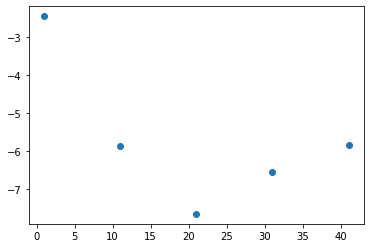

In [234]:
plt.scatter(list(k_info.keys()), list(k_info.values()))

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [181]:
def is_integer(cell):
    if int(cell) == float(cell):
        return True
    else:
        return False
    
def find_largest_divisor(num):
    res = []
    for i in range(1, num):
        if is_integer(num/i):
            res.append(i)
    return res[len(res)//2], num//res[len(res)//2]

# for topic_idx, topic in enumerate(lda.components_):
def get_top_k(topic_idx, topic, components, k):
    top_features = []
    for t in topic.argsort()[-k:]:
        if components[topic_idx, t] < 0.5:
            break
        else:
            top_features.append(t)
    return reversed(top_features)


In [236]:
def plot_top_words(num_topics, X, df, feature_names, n_top_words, title):
    res = []
    lda = LDA(n_components=num_topics, learning_method='online')
    model = lda.fit(X)
    doc_topic_prob = model.transform(X)
    doc_prob = defaultdict(int)
    topic_docs = defaultdict(list)
    info = defaultdict(list)
    for index, row in enumerate(doc_topic_prob):
        doc_prob[np.argmax(row)] += 1
        topic_docs[np.argmax(row)].append(df['Question'].iloc[index])
    total = len(doc_topic_prob)
    row, col = find_largest_divisor(num_topics)
    fig, axes = plt.subplots(row, col, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = list(get_top_15(topic_idx, topic, model.components_))#topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        info[topic_idx] = top_features
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        prob = 100 * doc_prob[topic_idx]/total
        res.append(prob)
        ax.set_title(f'Topic {topic_idx +1} | {prob:.2f}%',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()
    return res, topic_docs, model, info

_____
## 4. Script

In [183]:
# Choosing topics with Coherence score 

In [184]:
from collections import defaultdict

In [185]:
import matplotlib.pyplot as plt

In [186]:
import random

In [187]:
norm, question = subset['Norm Text Nouns'].values[0], subset['Question'].values[0]

In [188]:
question

'In the psychology of learning, it’s “the retention of association”; in “Cats”, it’s a showstopping song'

In [189]:
norm

['’ “', 'association ”', 'cat', '’', 'song memory']

In [190]:
jeopardy_df['Norm Text'] = jeopardy_df['Norm Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))




<ipython-input-190-b1338beb138f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeopardy_df['Norm Text'] = jeopardy_df['Norm Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [191]:
jeopardy_df

,Show Number,Air Date,Round,Category,Value,Question,Answer,Has Link,Year,Text,Text Nouns,Norm Text Nouns,Decade,Norm Text
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,False,2004,"For the last 8 years of his life, Galileo was ...","[galileo, house arrest, man 's theory, coperni...","[galileo, house arrest, man theory, copernicus]",2000s,last 8 year life galileo house arrest espousin...
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,False,2004,No. 2: 1912 Olympian; football star at Carlisl...,"[olympian, football star, carlisle, indian sch...","[olympian, football star, carlisle, indian sch...",2000s,2 1912 olympian football star carlisle indian ...
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,False,2004,The city of Yuma in this state has a record av...,"[yuma, record average, arizona]","[yuma, record average, arizona]",2000s,city yuma state record average 4055 hour sunsh...
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,False,2004,"In 1963, live on ""The Art Linkletter Show"", th...","[art linkletter, billionth burger, mcdonald]","[art linkletter, billionth burger, mcdonald]",2000s,1963 live art linkletter show company served b...
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,False,2004,"Signer of the Dec. of Indep., framer of the Co...","[signer, dec., indep., mass., john adams]","[signer, dec, indep, mass, john adam]",2000s,signer dec indep framer constitution mass seco...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216892,4999,2006-05-11,Jeopardy!,"RATED ""R""",$800,Sculptor Constantin Brancusi was born in this ...,Romania,False,2006,Sculptor Constantin Brancusi was born in this ...,"[sculptor constantin brancusi, eastern europea...","[sculptor constantin brancusi, eastern europea...",2000s,sculptor constantin brancusi born eastern euro...
216893,4999,2006-05-11,Jeopardy!,THE NEW YORK TIMES BUSINESS,$1000,"A Times writer's ""Scandalot"" featured Maurice ...",AIG,False,2006,"A Times writer's ""Scandalot"" featured Maurice ...","[writer 's, scandalot, maurice greenberg, ceo,...","[writer, scandalot, maurice greenberg, ceo, aig]",2000s,time writer scandalot featured maurice greenbe...
216894,4999,2006-05-11,Jeopardy!,LOVE SONGS IN GERMAN,$1000,"Joe Cocker: ""Sie Sind So Schon""","""You Are So Beautiful""",False,2006,"Joe Cocker: ""Sie Sind So Schon"" ""You Are So Be...","[joe cocker, sie sind, schon, beautiful]","[joe cocker, sie sind, schon, beautiful]",2000s,joe cocker sie sind schon beautiful
216895,4999,2006-05-11,Jeopardy!,FIRST IN OUR HEARTS,$1000,"Having no reeds, pipes or vibrating parts, thi...",(Laurens) Hammond,False,2006,"Having no reeds, pipes or vibrating parts, thi...","[man 's, laurens, hammond]","[man, laurens, hammond]",2000s,reed pipe vibrating part man 1935 organ first ...


In [192]:
subset['Norm Text'].values

array(['psychology learning ’ “ retention association ” “ cat ” ’ showstopping song memory',
       '’ discover gold black mark rubbing “ gold ” porcelain fool ’ gold',
       'brings worst werewolf full moon', ...,
       'unpunished maxwell anderson play rhoda roasted lightning movie finale bad seed',
       'variation poker worst hand win loball',
       'tightness per se kinetic force give knot holding power friction'],
      dtype=object)

In [204]:
jeopardy_df['Norm Text List'] = jeopardy_df['Norm Text'].apply(lambda x: [i for i in x.split() if len(i)>3])

<ipython-input-204-125fb192d002>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeopardy_df['Norm Text List'] = jeopardy_df['Norm Text'].apply(lambda x: [i for i in x.split() if len(i)>3])


In [ ]:
topics = defaultdict(list)
distribution = defaultdict(list)
# for decade in np.unique(jeopardy_df.Decade):
num_topics = 20
# 1. Get corpus subset
subset = jeopardy_df
corpus = subset['Norm Text List'].values
corpus = [' '.join(i) for i in corpus]
# 2. TFIDF and Vocab
vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,3), max_features=10000)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}
# 3. LDA model
odds, topic_docs, lda, info = plot_top_words(num_topics, X, subset, Vocab, 15, f"LDA on Jeopardy")
# 4. append odds
distribution[decade] = odds
# 4. Get user input for each topic:

for i in range(num_topics):
    preds = lda.transform(vectorizer.transform(topic_docs[i]))
    probs = np.array([np.max(p)/1 for p in preds])

    for ind_ in probs.argsort()[-5:]:
        doc = topic_docs[i][ind_]
        print(doc)
#             preds = lda.transform(vectorizer.transform([doc]))
#             conf = np.round(np.max(preds)/1,2)
#         print('\n\n'.join(doc))#, np.argmax(lda.transform(vectorizer.transform([doc]))), conf)
    print('Word:', info[i])
    topic = input(f"What topic in topic {i+1}?")
    topics[decade].append(topic)
    print()
    print()

In [61]:
doc_prob = defaultdict(int)
topic_docs = defaultdict(list)
for index, row in enumerate(doc_topic_prob):
    topic_docs[np.argmax(row)].append(jeopardy_df['Question'].iloc[index])

In [211]:
preds = lda.transform(vectorizer.transform(topic_docs[i]))

(5643, 20)

In [220]:
probs = np.array([np.max(p)/1 for p in preds])

In [217]:
probs.argsort()[-5:]

array([2347, 2241,    0,    4,   16])

In [207]:
for p in preds
preds = lda.transform(vectorizer.transform(topic_docs[i]))
conf = np.round(np.max(preds)/1,2)
print(conf)

0.68
0.05
0.05
0.05
0.68
0.05
0.05
0.33
0.61
0.66
0.49
0.44
0.61
0.32
0.5
0.61
0.75
0.39
0.43
0.48
0.58
0.61
0.63
0.58
0.34
0.28
0.05
0.35
0.52
0.28
0.59
0.25
0.37
0.05
0.62
0.47
0.53
0.5
0.34
0.28
0.35
0.05
0.43
0.32
0.35
0.41
0.22
0.17
0.24
0.05
0.32
0.44
0.38
0.5
0.05
0.64
0.26
0.53
0.46
0.23
0.34
0.55
0.38
0.29
0.2
0.46
0.21
0.05
0.52
0.28
0.2
0.56
0.45
0.3
0.35
0.25
0.38
0.59
0.18
0.46
0.25
0.05
0.05
0.21
0.43
0.52
0.05
0.52
0.23
0.05
0.05
0.61
0.27
0.05
0.42
0.46
0.36
0.29
0.4
0.33
0.35
0.38
0.37
0.26
0.44
0.43
0.2
0.21
0.17
0.6
0.32
0.24
0.3
0.33
0.61
0.23
0.38
0.24
0.05
0.19
0.19
0.05
0.52
0.65
0.36
0.38
0.52
0.35
0.05
0.34
0.45
0.51
0.17
0.34
0.05
0.18
0.28
0.26
0.33
0.37
0.35
0.05
0.21
0.24
0.22
0.27
0.2
0.28
0.05
0.05
0.21
0.2
0.41
0.23
0.32
0.05
0.34
0.25
0.18
0.6
0.38
0.3
0.25
0.48
0.52
0.05
0.31
0.21
0.6
0.33
0.2
0.05
0.52
0.25
0.21
0.3
0.32
0.19
0.33
0.2
0.28
0.36
0.26
0.23
0.18
0.05
0.22
0.17
0.05
0.36
0.35
0.52
0.19
0.6
0.34
0.37
0.5
0.2
0.15
0.42
0.28
0.43
0.36
0.28
0

KeyboardInterrupt: 

In [62]:
topic_docs

defaultdict(list,
            {1: ["For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",
              'The city of Yuma in this state has a record average of 4,055 hours of sunshine each year',
              'In 1963, live on "The Art Linkletter Show", this company served its billionth burger',
              'Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States',
              'In the title of an Aesop fable, this insect shared billing with a grasshopper',
              'No. 8: 30 steals for the Birmingham Barons; 2,306 steals for the Bulls',
              'This housewares store was named for the packaging its merchandise came in & was first displayed on',
              "This company's Accutron watch, introduced in 1960, had a guarantee of accuracy to within one minute a  month",
              'Outlaw: "Murdered by a traitor and a coward whose name is not worthy to appear here"',
        